# FinRL Full Workflow Example

This notebook demonstrates the complete workflow from data acquisition to strategy training/stock selection, backtesting, and trade execution (Alpaca paper trading).

## Workflow Overview

- Fetch S&P 500 components and define the research time period
- Use `data_fetcher` to fetch real fundamental data from **Yahoo Finance** (with `align_quarter_dates=True` and forward-looking `y_return` labels)
- Use `ml_strategy` for ML-based stock selection and export weights to CSV
- Use `backtest_engine` (bt library) to backtest the weights and output performance metrics
- Use `trade_executor` to display Alpaca account status, generate a dry-run plan, and optionally execute paper trades

## Data Sources

This notebook uses **Yahoo Finance** for fundamental and price data — no API key required.

## Prerequisites

- Install dependencies: run `pip install -r requirements.txt` from the project root
- Alpaca API keys are only needed for paper trading (Section 6+). Sections 1–5 work without any API keys.
- To use Alpaca, configure `.env` (see `README.md` / `.env.example`)
- The first run will generate cache files in `data/cache/` to avoid redundant data fetching


In [1]:
%pip install -r ../requirements.txt

  Using cached tzlocal-5.3.1-py3-none-any.whl.metadata (7.6 kB)
Using cached tzlocal-5.3.1-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%cd "~/Downloads/FinRL-Trading"

C:\Users\vrang\Downloads\FinRL-Trading


In [ ]:
# # Environment and path setup
# import os, sys, logging
# from datetime import datetime, timedelta
# from pathlib import Path

# # Infer project root from working directory (this file is in examples/)
# nb_dir = Path().resolve()
# project_root = str(nb_dir.parent)
# print(f"project_root: {project_root}")
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)
#     sys.path.insert(0, os.path.join(project_root, 'src'))

# logging.basicConfig(level=logging.INFO)


In [2]:
# Data source initialization and stock universe / date range setup
from src.data.data_fetcher import get_data_manager, fetch_sp500_tickers
from datetime import datetime, timedelta

# Initialize the data manager with Yahoo Finance (no API key required)
manager = get_data_manager(preferred_source='YAHOO')
print(manager.get_source_info())

# Fetch S&P 500 components (falls back to a default list on failure)
tickers = fetch_sp500_tickers(preferred_source='YAHOO')
print(f"Total tickers: {len(tickers)} (show first 15)")
print(tickers.head(15))

# Research time period (~2.5 years — Yahoo Finance only provides the last 4-5 quarters of fundamental data)
end_date_dt = datetime.now()
start_date_dt = end_date_dt - timedelta(days=int(2.5 * 365))

start_date = start_date_dt.strftime('%Y-%m-%d')
end_date = end_date_dt.strftime('%Y-%m-%d')
print(f"Research period: {start_date} -> {end_date}")


project_root: C:\Users\vrang\Downloads\FinRL-Trading
project_root: C:\Users\vrang\Downloads\FinRL-Trading
{'current_source': 'YAHOO', 'available_sources': ['FMP', 'YAHOO'], 'cache_dir': './data/cache'}
Total tickers: 503 (show first 15)
   tickers                 sectors dateFirstAdded
0      MMM             Industrials     1957-03-04
1      AOS             Industrials     2017-07-26
2      ABT             Health Care     1957-03-04
3     ABBV             Health Care     2012-12-31
4      ACN  Information Technology     2011-07-06
5     ADBE  Information Technology     1997-05-05
6      AMD  Information Technology     2017-03-20
7      AES               Utilities     1998-10-02
8      AFL              Financials     1999-05-28
9        A             Health Care     2000-06-05
10     APD               Materials     1985-04-30
11    ABNB  Consumer Discretionary     2023-09-18
12    AKAM  Information Technology     2007-07-12
13     ALB               Materials     2016-07-01
14     ARE   

C:\Users\vrang\Downloads\FinRL-Trading\src\data\data_fetcher.py:1062: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


In [3]:
# Fetch fundamental data (align_quarter_dates=True) and validate y_return
import pandas as pd
from src.data.data_fetcher import fetch_fundamental_data

# To speed up the demo, you can limit the number of tickers, e.g. first 80; expand as needed
# tickers_small = tickers[:80]

fundamentals = fetch_fundamental_data(
    tickers,
    start_date,
    end_date,
    align_quarter_dates=True,    # Shift trade dates ~2 months after earnings release to align across companies
    preferred_source='YAHOO'     # Use Yahoo Finance (no API key needed)
)
print(f"fundamentals shape: {fundamentals.shape}")

# Basic validation: must contain y_return (next-quarter return computed by fetcher)
if 'y_return' not in fundamentals.columns:
    raise ValueError("fundamentals missing y_return — check data_fetcher implementation")

# Drop sector/gsector columns — not used for basic ML stock selection
for col in ['sector', 'gsector']:
    if col in fundamentals.columns:
        fundamentals = fundamentals.drop(columns=[col])
        print(f"Dropped '{col}' column from fundamentals")

# Save a clean copy of the data
clean_path = 'data/fundamentals.csv'
fundamentals.to_csv(clean_path, index=False)
print(f"Saved cleaned fundamentals to {clean_path}")
print(f"Columns: {list(fundamentals.columns)}")


Fetching Yahoo Finance data: 100%|██████████| 503/503 [06:59<00:00,  1.20it/s]

fundamentals shape: (2794, 20)
Dropped 'gsector' column from fundamentals
Saved cleaned fundamentals to data/fundamentals.csv
Columns: ['gvkey', 'datadate', 'tic', 'adj_close_q', 'EPS', 'BPS', 'DPS', 'cur_ratio', 'quick_ratio', 'cash_ratio', 'acc_rec_turnover', 'debt_ratio', 'debt_to_equity', 'pe', 'ps', 'pb', 'roe', 'net_income_ratio', 'y_return']


In [4]:
# ML stock selection and save weights CSV
from src.strategies.base_strategy import StrategyConfig
from src.strategies.ml_strategy import MLStockSelectionStrategy
import os
import pandas as pd

# Load cleaned fundamental data (sector/gsector columns have been removed)
fundamentals = pd.read_csv('data/fundamentals.csv')
print(f"Loaded fundamentals: {fundamentals.shape[0]} rows, {fundamentals.shape[1]} columns")

config = StrategyConfig(
    name="ML Stock Selection",
    description="Machine learning based stock selection"
)
strategy = MLStockSelectionStrategy(config)

data_dict = {'fundamentals': fundamentals}

# Strategy parameters
test_quarters = 1      # Reduced for Yahoo Finance (limited to ~4-5 quarters of data)
top_quantile = 0.9

# Run ML stock selection using single prediction mode
res = strategy.generate_weights(
    data=data_dict,
    prediction_mode='single',
    test_quarters=test_quarters,
    top_quantile=top_quantile,
    weight_method='equal',
    confirm_mode='today',
    execution_date=end_date  # Order execution date
)

weights = res.weights.copy()
print(f"weights rows: {len(weights)}")

# Save weights
out_dir = 'data'
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'ml_weights_today.csv')
weights.to_csv(out_path, index=False)
print(f"Saved weights to {out_path}")


project_root: C:\Users\vrang\Downloads\FinRL-Trading
Loaded fundamentals: 2794 rows, 19 columns
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3569
[LightGBM] [Info] Number of data points in the train set: 2621, number of used features: 14
[LightGBM] [Info] Start training from score 0.018719


c:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam\.finrl_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\vrang\Downloads\FinRL-Trading\.claude\worktrees\xenodochial-khayyam\.finrl_venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


weights rows: 2
Saved weights to data\ml_weights_today.csv


In [4]:
# Backtest weights using the bt library and output metrics
import pandas as pd
from datetime import datetime, timedelta
from src.backtest.backtest_engine import BacktestConfig, BacktestEngine
from src.data.data_fetcher import fetch_price_data

# Load weights
weights_path = 'data\ml_weights_today.csv'  # From previous cell
weights_raw = pd.read_csv(weights_path)
assert {'date','gvkey','weight'}.issubset(weights_raw.columns), 'Weight file must contain date/gvkey/weight'
weights_raw['date'] = pd.to_datetime(weights_raw['date'])
weights_raw['gvkey'] = weights_raw['gvkey'].astype(str)
weights_raw = weights_raw.sort_values(['date','gvkey'])

# Create weight matrix (rows: dates, columns: tickers)
weight_signals = (
    weights_raw
    .pivot_table(index='date', columns='gvkey', values='weight', aggfunc='sum')
    .fillna(0.0)
    .sort_index()
)

# Filter out rows where all weights are zero
weight_signals = weight_signals.loc[(weight_signals.sum(axis=1) > 0.0)]
assert len(weight_signals) > 0, 'Weight matrix is empty — cannot run backtest'

# Backtest time period
# Extend start date 90 days before earliest weight and end date to today
# so bt has enough price history and can align weight dates to trading days
t_min = weight_signals.index.min()
t_max = weight_signals.index.max()
t_start = (t_min - timedelta(days=90)).strftime('%Y-%m-%d')
t_end = datetime.now().strftime('%Y-%m-%d')

print(f"Weight dates: {t_min.strftime('%Y-%m-%d')} to {t_max.strftime('%Y-%m-%d')}")
print(f"Price data range: {t_start} to {t_end}")

cfg = BacktestConfig(
    start_date=t_start,
    end_date=t_end,
    rebalance_freq='Q',
    initial_capital=1000000.0
)

# Fetch price data from Yahoo Finance
tickers_bt = weight_signals.columns.tolist()
prices_long = fetch_price_data(tickers_bt, cfg.start_date, cfg.end_date, preferred_source='YAHOO')

if prices_long is None or len(prices_long) == 0:
    raise ValueError(f'No price data fetched for {len(tickers_bt)} tickers between {t_start} and {t_end}')
print(f"Fetched price data: {len(prices_long)} rows for {prices_long['gvkey'].nunique()} tickers")

# Run backtest
engine = BacktestEngine(cfg)
price_data_bt = engine._prepare_price_data_for_bt(prices_long)
print(f"Price matrix: {price_data_bt.shape[0]} trading days, {price_data_bt.shape[1]} tickers")
print(f"Price date range: {price_data_bt.index.min().strftime('%Y-%m-%d')} to {price_data_bt.index.max().strftime('%Y-%m-%d')}")

# Align weight dates to nearest available trading day
# Use 'nearest' so weights snap to the closest trading day in the price data
from pandas import DataFrame
common_cols = [c for c in weight_signals.columns if c in price_data_bt.columns]
if len(common_cols) == 0:
    raise ValueError(
        f'No overlapping tickers between weights ({list(weight_signals.columns[:5])}) '
        f'and prices ({list(price_data_bt.columns[:5])})'
    )
weight_signals = weight_signals[common_cols]
trading_index = price_data_bt.index
pos = trading_index.get_indexer(weight_signals.index, method='nearest')
mask = pos != -1
weight_signals = weight_signals.iloc[mask]
weight_signals.index = trading_index[pos[mask]]

# Remove stocks with no price on each date and normalize
aligned = []
for dt, row in weight_signals.iterrows():
    prices_today = price_data_bt.loc[dt, row.index]
    valid_cols = prices_today.dropna().index.tolist()
    if len(valid_cols) == 0:
        continue
    row_valid = row[valid_cols]
    s = row_valid.sum()
    if s <= 0:
        continue
    aligned.append((dt, (row_valid / s)))

if aligned:
    weight_signals = DataFrame({dt: vec for dt, vec in aligned}).T.sort_index()
else:
    raise ValueError('No valid weight rows after alignment')

# Normalize rows again
weight_signals = weight_signals.div(weight_signals.sum(axis=1), axis=0).fillna(0)

result = engine.run_backtest('ML Weights Strategy', prices_long, weight_signals)
print(f"Backtest period: {t_start} to {t_end}")
print(f"Portfolio annualized return: {result.annualized_return:.2%}")
for bm, ann in (result.benchmark_annualized or {}).items():
    print(f"Benchmark {bm} annualized return: {ann:.2%}")

metrics_df = result.to_metrics_dataframe()
metrics_df

Weight dates: 2026-01-30 to 2026-01-30
Price data range: 2025-11-01 to 2026-02-14
project_root: C:\Users\vrang\Downloads\FinRL-Trading


Fetching Yahoo price data: 100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


Fetched price data: 142 rows for 2 tickers
Price matrix: 71 trading days, 2 tickers
Price date range: 2025-11-03 to 2026-02-13


100%|██████████| 1/1 [00:00<00:00, 13.78it/s]
C:\Users\vrang\Downloads\FinRL-Trading\src\backtest\backtest_engine.py:349: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
100%|██████████| 1/1 [00:00<?, ?it/s]
C:\Users\vrang\Downloads\FinRL-Trading\src\backtest\backtest_engine.py:349: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
100%|██████████| 1/1 [00:00<00:00, 53.52it/s]

Backtest period: 2025-11-01 to 2026-02-14
Portfolio annualized return: 12.44%
Benchmark SPY annualized return: -0.39%
Benchmark QQQ annualized return: -16.61%



C:\Users\vrang\Downloads\FinRL-Trading\src\backtest\backtest_engine.py:349: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)


,annual_return,annual_volatility,annualized_return,kurtosis,max_drawdown,monthly_return,monthly_sharpe,monthly_sortino,monthly_volatility,sharpe_ratio,skewness,sortino_ratio,total_return
ML Weights Strategy,0.124377,0.215717,0.124377,14.230137,-0.082181,0.008411,0.480796,0.000000,0.017495,0.576574,-0.033156,0.310321,0.033611
SPY,-0.003869,0.121220,-0.003869,0.442866,-0.046033,-0.000213,-0.017282,-0.020764,0.012349,-0.031919,-0.315771,-0.043280,-0.001082
QQQ,-0.166067,0.170256,-0.166067,0.001075,-0.074325,-0.012448,-0.624098,-0.907012,0.019945,-0.975396,-0.224093,-1.358940,-0.049450


## Alpaca Paper Trading

In [6]:
# Display Alpaca account status, generate dry-run plan, and optionally execute paper trades
import os
from src.trading.trade_executor import create_trade_executor_from_env
import pandas as pd

# Only runs if Alpaca API is configured. Otherwise raises an error with instructions.
try:
    executor = create_trade_executor_from_env()
    print("Trade executor initialized. Accounts:", executor.alpaca.get_available_accounts())

    weights_path = 'data\ml_weights_today.csv'  # From ML stock selection cell
    # Use the weights from the previous cell, take the latest rebalance date
    df = pd.read_csv(weights_path)
    df['date'] = pd.to_datetime(df['date']).dt.date
    latest_date = df['date'].max()
    df_latest = df[df['date'] == latest_date].copy()

    # Normalize and convert to target weights
    df_latest = df_latest.groupby('gvkey', as_index=False)['weight'].sum()
    df_latest = df_latest[df_latest['weight'] > 0]
    s = df_latest['weight'].sum()
    if s <= 0:
        raise ValueError('Total weight on latest rebalance date is zero')
    df_latest['weight'] = df_latest['weight'] / s
    target_weights = {row['gvkey']: float(row['weight']) for _, row in df_latest.iterrows()}

    # Generate dry-run plan (no order submission)
    plan = executor.alpaca.execute_portfolio_rebalance(
        target_weights,
        account_name='default',
        dry_run=True
    )
    print('Dry-run plan generated:')
    print('Market open:', plan.get('market_open'))
    print('Used TIF:', plan.get('used_time_in_force'))
    print('Planned sells:', len(plan.get('orders_plan', {}).get('sell', [])))
    print('Planned buys :', len(plan.get('orders_plan', {}).get('buy',  [])))


except Exception as e:
    print('Alpaca initialization or execution failed:', e)
    print('To enable this cell, configure .env and refer to the Alpaca setup instructions in README.')

Trade executor initialized. Accounts: ['default']
Dry-run plan generated:
Market open: False
Used TIF: day
Planned sells: 40
Planned buys : 2


In [7]:
plan.get('orders_plan', {}).get('buy',  [])

[{'symbol': 'JBL',
  'quantity': 30.332638905226833,
  'side': 'buy',
  'order_type': 'market',
  'time_in_force': 'day'},
 {'symbol': 'MU',
  'quantity': 18.794297619047615,
  'side': 'buy',
  'order_type': 'market',
  'time_in_force': 'day'}]

In [8]:
# Submit orders based on market status (paper trading)
# use_opg = os.getenv('USE_OPG', 'false').lower() == 'true'
use_opg = True
if plan.get('market_open'):
    submit = executor.alpaca.execute_portfolio_rebalance(
        target_weights,
        account_name='default'
    )
    print('Submitted during market hours. Orders placed:', submit.get('orders_placed', 0))
else:
    if use_opg:
        submit = executor.alpaca.execute_portfolio_rebalance(
            target_weights,
            account_name='default',
            market_closed_action='opg'
        )
        print('Submitted as OPG. Orders placed:', submit.get('orders_placed', 0))
    else:
        print('Market is closed. Skipping submission. Set USE_OPG=true to submit OPG at open.')

Submitted as OPG. Orders placed: 42


project_root: C:\Users\vrang\Downloads\FinRL-Trading
[DEBUG] Portfolio history from 2023-02-28 to 2026-02-14
***************start_date is 2023-02-26******************
***************end_date is 2026-02-16******************


Fetching Yahoo price data: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]
INFO:src.data.data_fetcher:Retrieved 1490 price records from database


tic                SPY         QQQ
date                              
2026-02-02  695.409973  626.140015
2026-02-03  689.530029  616.520020
2026-02-04  686.190002  605.750000
2026-02-05  677.619995  597.030029
2026-02-06  690.619995  609.650024
2026-02-09  693.950012  614.320007
2026-02-10  692.119995  611.469971
2026-02-11  691.960022  613.109985
2026-02-12  681.270020  600.640015
2026-02-13  681.750000  601.919983

Performance Metrics (Aligned):
               Metric  Portfolio        SPY        QQQ
           Start Date 2023-03-14 2023-03-14 2023-03-14
             End Date 2025-10-31 2025-10-31 2025-10-31
     Total Return (%)     65.24%     80.60%    115.08%
    Annual Return (%)     38.57%     46.80%     64.44%
Annual Volatility (%)     28.77%     23.78%     28.32%
         Sharpe Ratio       1.27       1.88       2.21
     Max Drawdown (%)    -19.98%    -14.53%    -16.90%


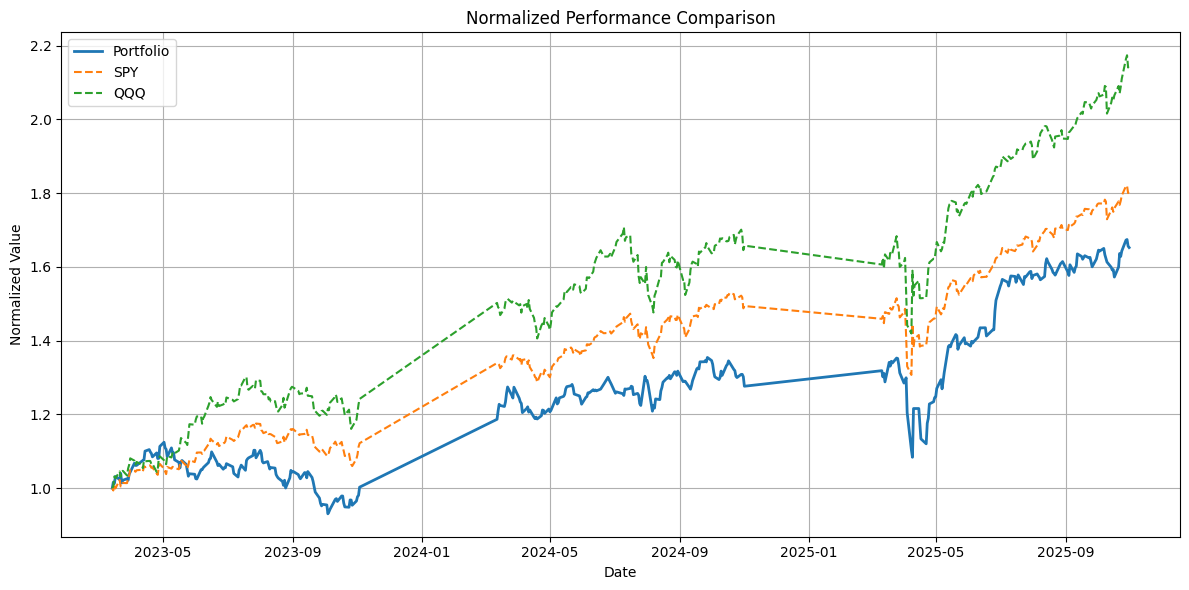

In [9]:
# Read Alpaca account history and compare against benchmarks (SPY/QQQ)
import logging
from datetime import datetime, timedelta, timezone
from src.trading.performance_analyzer import (
    create_alpaca_account_from_env, AlpacaManager,
    get_first_order_date, get_portfolio_history,
    get_benchmark_data, display_metrics_table, plot_performance
)

try:
    logging.basicConfig(level=logging.INFO)
    # Create AlpacaManager
    account = create_alpaca_account_from_env()
    manager = AlpacaManager([account])

    # Time range: from first order date to now (you can also customize the window)
    end_date = datetime.now(timezone.utc)
    first_order_date = get_first_order_date(manager)
    if first_order_date is None:
        raise RuntimeError('Cannot determine first order date — ensure account has trade history or check API permissions')

    # Ensure we fetch data through end_date (FMP requires +1 day), and start_date-1 for boundary
    start_date = first_order_date - timedelta(days=1)
    start_date_str = start_date.date().isoformat()
    fmp_end_date = end_date + timedelta(days=1)
    end_date_str = fmp_end_date.date().isoformat()

    # Fetch account equity curve and benchmark data
    portfolio_df = get_portfolio_history(manager, start_date, end_date)
    benchmark_df = get_benchmark_data(start_date_str, end_date_str)

    # Align metrics and plot (handles alignment and nulls internally)
    display_metrics_table(portfolio_df, benchmark_df)
    plot_performance(portfolio_df, benchmark_df)

except Exception as e:
    print('Paper trading performance analysis failed:', e)
    print('To enable this cell, configure Alpaca API in .env and ensure the account has order history.')

## Cancel All Open Alpaca Orders (Paper Trading)

The example below lists the current number of open orders and calls `cancel_all_orders` to batch-cancel all open orders. Only runs when Alpaca API (Paper Trading) is properly configured.


In [ ]:
# Batch cancel all open orders
from src.trading.performance_analyzer import create_alpaca_account_from_env, AlpacaManager

try:
    account = create_alpaca_account_from_env()
    manager = AlpacaManager([account])

    # Query current open orders
    open_orders = manager.get_orders(status='open', limit=200)
    print('Open orders:', len(open_orders))

    # Cancel all
    cancelled = manager.cancel_all_orders()
    print('Cancelled orders:', cancelled)

except Exception as e:
    print('Failed to cancel open orders:', e)
    print('Please verify Alpaca API is configured and the account is set to Paper Trading.')
